In [1]:
import json
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import time
import pandas as pd

Mounted at /content/drive


In [2]:
# import mutations et nb distance
chemin_general = "drive/MyDrive/Colab Notebooks/Data science project/"
nb_distance = pd.read_csv(chemin_general + "BDD_output/bdd_nb_distance.csv")
nb_distance.set_index("idmutinvar", inplace=True)
nb_distance["arrondissement"] = nb_distance["l_codinsee"].astype(str).apply(lambda x : x[3:]+ "e arr"
                                                                          if x[3:].startswith("0") == False
                                                                          else x[4:] + "e arr")
nb_distance = nb_distance.loc[nb_distance['sbati'] != 0]
nb_distance.loc[:,"prixm2"] = nb_distance["valeurfonc"] / nb_distance["sbati"]
nb_distance.drop(["anneemut","datemut"]+
                ["id_parcelles","coor_parcelles","long_parcelles","lat_parcelles","coddep","l_codinsee"]+
                ["valeurfonc","sbati"],
                inplace=True, axis=1)

<ipython-input-2-eca7a23563b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nb_distance.loc[:,"prixm2"] = nb_distance["valeurfonc"] / nb_distance["sbati"]
<ipython-input-2-eca7a23563b0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nb_distance.drop(["anneemut","datemut"]+


In [3]:
# import dist_min
chemin_general = "drive/MyDrive/Colab Notebooks/Data science project/"
data_min = pd.read_csv(chemin_general + "BDD_output/bdd_min_dist.csv")
data_min.set_index("idmutinvar", inplace=True)

In [4]:
# merge dans un final dataset
final_data = pd.merge(nb_distance, data_min.filter(regex='^min_dist'), on='idmutinvar')

Retrait des valeurs extrêmes qui biaisent le modele

<Axes: >

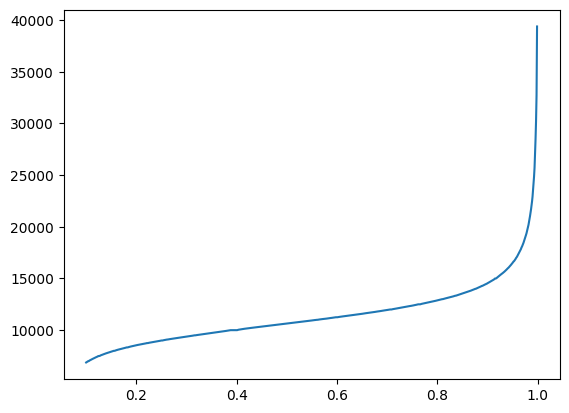

In [5]:
final_data["prixm2"].quantile(np.arange(.1, 1, 0.001)).plot()

In [6]:
threshold = 20000
#print(f"{final_data.loc[final_data['prixm2']> threshold].shape[0]}  rows are removed")
#print(f"{final_data.shape[0]}  rows are removed")

print(f"{final_data.loc[(final_data['prixm2'] < 6000) |  (final_data['prixm2'] > 15000)].shape[0] / final_data.shape[0]}%  rows are removed")
final_data = final_data.loc[final_data['prixm2']<20000]
final_data = final_data.loc[final_data['prixm2']>6000]

0.1583830293279236%  rows are removed


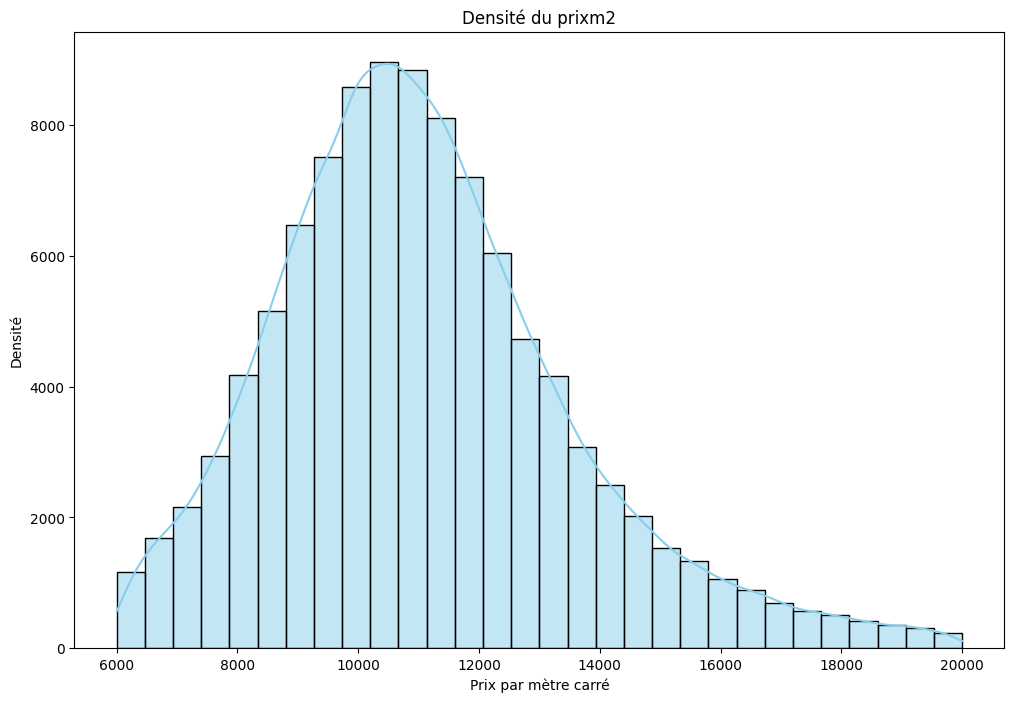

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
final_data = final_data.loc[final_data['prixm2']<20000]

# Assurez-vous que Seaborn est installé : pip install seaborn

plt.figure(figsize=(12, 8))
sns.histplot(final_data['prixm2'], kde=True, bins=30, color='skyblue')

plt.xlabel('Prix par mètre carré')
plt.ylabel('Densité')
plt.title('Densité du prixm2')
plt.show()


# LASSO Model

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import Lasso, Ridge
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [10]:
final_data = final_data.filter(regex='^(?!min_dist).*')
#final_data = final_data.loc[:, final_data.columns[final_data.columns.str.startswith('min_dist')] | ['prixm2', 'nb_catering', 'nb_food_market', 'nb_fashion_shop','nb_culture_shop', 'nb_gare_unique', 'nb_velib', 'arrondissement']]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(final_data.drop("prixm2",axis=1),
                                                   final_data["prixm2"],
                                                   test_size=0.2,
                                                   random_state=42)

print("Main dataset :")
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

sample = final_data.sample(30000, random_state=42)
X_sample, X_valid, y_sample, y_valid = train_test_split(sample.drop("prixm2",axis=1),
                                                        sample["prixm2"],
                                                        test_size=0.2,
                                                        random_state=42)

print("\nSample :")
print(X_sample.shape)
print(X_valid.shape)
print(y_sample.shape)
print(y_valid.shape)

Main dataset :
(82684, 22)
(20672, 22)
(82684,)
(20672,)

Sample :
(24000, 22)
(6000, 22)
(24000,)
(6000,)


In [ ]:
categorical_cols = final_data.drop('prixm2',axis=1).select_dtypes(include=['object']).columns
numerical_cols = final_data.drop('prixm2',axis=1).select_dtypes(exclude=['object']).columns

# preprocessing
numeric_transformer = StandardScaler() # (x-mean)/std
categorical_transformer = OneHotEncoder(sparse_output=False) #drop='first' retiré car on a pas de categorie binaire


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X_train_trans = pd.DataFrame(preprocessor.fit_transform(X_train))
print(X_train_trans.shape)
X_test_trans = pd.DataFrame(preprocessor.fit_transform(X_test))
print(X_test_trans.shape)
X_sample_trans = pd.DataFrame(preprocessor.fit_transform(X_sample))
print(X_sample_trans.shape)
X_valid_trans = pd.DataFrame(preprocessor.fit_transform(X_valid))
print(X_valid_trans.shape)

#libtypbien a 3 columns et arrondissements 20 donc 21 colonnes de plus



(76670, 43)
(19168, 43)
(8000, 43)
(2000, 43)


# Lasso

In [ ]:
start_time = time.time()

lasso_model = Lasso(max_iter=50000)

lasso_param = {'alpha':  np.arange(0.001, 1, 0.05) }

cv = KFold(n_splits=5, shuffle=True, random_state=42)

rmse = make_scorer(mean_squared_error, squared=False)

grid_lasso = GridSearchCV(estimator=lasso_model,
                          param_grid = lasso_param,
                          scoring=rmse,
                          refit='r2',
                          cv=cv,
                          error_score='raise',
                          n_jobs=-1)

grid_lasso.fit(X_sample_trans, y_sample)

print("LASSO RESULTS")
print(f"Mean square error : {grid_lasso.cv_results_['mean_test_score'].mean()}")
print(f"Best parameter : {grid_lasso.best_params_}")
#print(f"Best score : {grid_lasso.best_score_}")

print(f"{int(round(time.time() - start_time,0)//60)} min {int(round(time.time() - start_time,0)%60)}")

LASSO RESULTS
Mean square error : 1720.0325940924395
Best parameter : {'alpha': 0.001}
0 min 34

LASSO RESULTS
Mean Squared Error (MSE): 1754.8321800328524
R^2: 0.20242486746104504


In [ ]:
print("\nLASSO RESULTS")
lasso_model = Lasso(alpha=grid_lasso.best_params_['alpha'],
                 fit_intercept=True,
                 max_iter=50000)
lasso_model.fit(X_sample_trans, y_sample)
y_pred_valid_lm = lasso_model.predict(X_valid_trans)

print('Mean Squared Error (MSE):', np.sqrt(metrics.mean_squared_error(y_valid, y_pred_valid_lm)))
print('R^2:', metrics.r2_score(y_valid, y_pred_valid_lm))


LASSO RESULTS
Mean Squared Error (MSE): 1754.8321800328524
R^2: 0.20242486746104504


In [ ]:
non_zero_coefficients = sum(lasso_model.coef_ != 0)
non_zero_coefficients

50

# Ridge

In [ ]:
start_time = time.time()

ridge_model = Ridge(max_iter=5000)

ridge_param = {'alpha':  np.arange(1, 5, 0.01) }

cv = KFold(n_splits=5, shuffle=True, random_state=42)

rmse = make_scorer(mean_squared_error, squared=False)

grid_ridge = GridSearchCV(estimator=ridge_model,
                          param_grid = ridge_param,
                          scoring=rmse,
                          refit='r2',
                          cv=cv,
                          error_score='raise',
                          n_jobs=-1)

grid_ridge.fit(X_sample_trans, y_sample)

print("RIDGE RESULTS")
print(f"Mean square error : {grid_ridge.cv_results_['mean_test_score'].mean()}")
print(f"Best parameter : {grid_ridge.best_params_}")
#print(f"Best score : {grid_ridge.best_score_}")
print(f"{int(round(time.time() - start_time,0)//60)} min {int(round(time.time() - start_time,0)%60)}")

RIDGE RESULTS
Mean square error : 1720.3151611063245
Best parameter : {'alpha': 1.0}
0 min 12


In [ ]:
print("\nRIDGE RESULTS")

ridge_model = Ridge(alpha=grid_ridge.best_params_['alpha'],
                 fit_intercept=True,
                 max_iter=5000)

ridge_model.fit(X_sample_trans, y_sample)
y_pred_valid_rm = ridge_model.predict(X_valid_trans)

print('Mean Squared Error (MSE):', np.sqrt(metrics.mean_squared_error(y_valid, y_pred_valid_rm)))
print('R^2:', metrics.r2_score(y_valid, y_pred_valid_rm))


RIDGE RESULTS
Mean Squared Error (MSE): 1754.8903148016084
R^2: 0.2023720218220686


# Random Forest

In [ ]:
start_time = time.time()

rf = RandomForestRegressor()

param_grid = {
    #'bootstrap': [True],
    'max_depth': [30,50,100, 150, 200],
    'max_features': [X_sample_trans.shape[1]+1],
    #'min_samples_leaf' : [5, 10,20,50],
    #'min_samples_split': [5,10,20],
    'n_estimators': [50,100,200]
}


rmse = make_scorer(mean_squared_error, squared=False)

grid_search = GridSearchCV(estimator = rf,
                           param_grid = param_grid,
                           cv = KFold(n_splits=5, shuffle=True),
                           n_jobs = -1,
                           verbose = 2,
                           scoring = rmse,
                           error_score='raise'
                           )


grid_search.fit(X_sample_trans, y_sample)
print(f"{int(round(time.time() - start_time,0)//60)} min {int(round(time.time() - start_time,0)%60)}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
14 min 1


In [ ]:
grid_search.best_params_['max_depth']

100

# Results

In [ ]:
print("\nLASSO RESULTS")
lasso_model = Lasso(alpha=grid_lasso.best_params_['alpha'],
                 fit_intercept=True,
                 max_iter=5000)
lasso_model.fit(X_sample_trans, y_sample)
y_pred_valid_lm = lasso_model.predict(X_valid_trans)

print('Mean Squared Error (MSE):', np.sqrt(metrics.mean_squared_error(y_valid, y_pred_valid_lm)))
print('R^2:', metrics.r2_score(y_valid, y_pred_valid_lm))


print("\nRIDGE RESULTS")

ridge_model = Ridge(alpha=grid_ridge.best_params_['alpha'],
                 fit_intercept=True,
                 max_iter=5000)

ridge_model.fit(X_sample_trans, y_sample)
y_pred_valid_rm = ridge_model.predict(X_valid_trans)

print('Mean Squared Error (MSE):', np.sqrt(metrics.mean_squared_error(y_valid, y_pred_valid_rm)))
print('R^2:', metrics.r2_score(y_valid, y_pred_valid_rm))



print("\nRANDOM FOREST RESULTS")
rf_model = RandomForestRegressor(max_features =  grid_search.best_params_['max_features'],
                                 max_depth = grid_search.best_params_['max_depth'],
                                 n_estimators =  grid_search.best_params_['n_estimators']
                                )
rf_model.fit(X_sample_trans, y_sample)
y_pred_valid_rf = rf_model.predict(X_valid_trans)

print('Mean Squared Error (MSE):', np.sqrt(metrics.mean_squared_error(y_valid, y_pred_valid_rf)))
print('R^2:', metrics.r2_score(y_valid, y_pred_valid_rf))



LASSO RESULTS
Mean Squared Error (MSE): 2871.9409948076436
R^2: 0.06388538974814939

RIDGE RESULTS
Mean Squared Error (MSE): 2871.9031663056116
R^2: 0.06391005012960027

RANDOM FOREST RESULTS
Mean Squared Error (MSE): 3001.0299165251654
R^2: -0.02215944812272652
